Set the enviroment

In [1]:
%config IPCompleter.greedy=True

In [204]:
pip install -U imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import scipy 
import seaborn as sns
from math import sqrt
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from scipy.stats import randint as sp_randint
from scipy.stats import expon

from time import time

#estimators
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from imblearn.ensemble import BalancedRandomForestClassifier


#model metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

# cross validation
from sklearn.model_selection import train_test_split
#randomized search
from sklearn.model_selection import RandomizedSearchCV

In [3]:
#data
credit_preprocessed = pd.read_csv("credit_preprocessed.csv", header = 0)
credit_preprocessed.head()

,LIMIT_BAL,BILL_AMT1,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month,"AGE_(27.0, 31.0]",...,PAY_6_7,PAY_6_6,PAY_6_5,PAY_6_4,PAY_6_3,PAY_6_2,PAY_6_1,PAY_6_0,PAY_6_-1,PAY_6_-2
0,20000,3913,0,689,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,120000,2682,0,1000,1000,1000,0,2000,1,0,...,0,0,0,0,0,1,0,0,0,0
2,90000,29239,1518,1500,1000,1000,1000,5000,0,0,...,0,0,0,0,0,0,0,1,0,0
3,50000,46990,2000,2019,1200,1100,1069,1000,0,0,...,0,0,0,0,0,0,0,1,0,0
4,50000,8617,2000,36681,10000,9000,689,679,0,0,...,0,0,0,0,0,0,0,1,0,0


In [4]:
credit_preprocessed.columns

Index(['LIMIT_BAL', 'BILL_AMT1', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default payment next month',
       'AGE_(27.0, 31.0]', 'AGE_(31.0, 37.0]', 'AGE_(37.0, 43.0]',
       'AGE_(43.0, 79.0]', 'SEX_2', 'EDUCATION_1', 'EDUCATION_2',
       'EDUCATION_3', 'EDUCATION_4', 'EDUCATION_5', 'EDUCATION_6',
       'MARRIAGE_1', 'MARRIAGE_2', 'MARRIAGE_3', 'PAY_0_8', 'PAY_0_7',
       'PAY_0_6', 'PAY_0_5', 'PAY_0_4', 'PAY_0_3', 'PAY_0_2', 'PAY_0_1',
       'PAY_0_0', 'PAY_0_-1', 'PAY_0_-2', 'PAY_2_8', 'PAY_2_7', 'PAY_2_6',
       'PAY_2_5', 'PAY_2_4', 'PAY_2_3', 'PAY_2_2', 'PAY_2_1', 'PAY_2_0',
       'PAY_2_-1', 'PAY_2_-2', 'PAY_3_8', 'PAY_3_7', 'PAY_3_6', 'PAY_3_5',
       'PAY_3_4', 'PAY_3_3', 'PAY_3_2', 'PAY_3_1', 'PAY_3_0', 'PAY_3_-1',
       'PAY_3_-2', 'PAY_4_8', 'PAY_4_7', 'PAY_4_6', 'PAY_4_5', 'PAY_4_4',
       'PAY_4_3', 'PAY_4_2', 'PAY_4_1', 'PAY_4_0', 'PAY_4_-1', 'PAY_4_-2',
       'PAY_5_8', 'PAY_5_7', 'PAY_5_6', 'PAY_5_5', 'PAY_5_4', 'PAY_5

# 1. Preprocessing


### A. Casting type of variables from int to category

In [5]:
for cols in credit_preprocessed.columns[8:]:
    credit_preprocessed[cols] = credit_preprocessed[cols].astype ('category')
   

In [6]:
credit_preprocessed.dtypes

LIMIT_BAL                        int64
BILL_AMT1                        int64
PAY_AMT1                         int64
PAY_AMT2                         int64
PAY_AMT3                         int64
PAY_AMT4                         int64
PAY_AMT5                         int64
PAY_AMT6                         int64
default payment next month    category
AGE_(27.0, 31.0]              category
AGE_(31.0, 37.0]              category
AGE_(37.0, 43.0]              category
AGE_(43.0, 79.0]              category
SEX_2                         category
EDUCATION_1                   category
EDUCATION_2                   category
EDUCATION_3                   category
EDUCATION_4                   category
EDUCATION_5                   category
EDUCATION_6                   category
MARRIAGE_1                    category
MARRIAGE_2                    category
MARRIAGE_3                    category
PAY_0_8                       category
PAY_0_7                       category
PAY_0_6                  

### B. Defining Features and dependen Variable

In [7]:
#features
features = credit_preprocessed.loc[:, credit_preprocessed.columns != 'default payment next month']
print('Summary of feature sample')
features.head()
##here we use np.r_ to select a diferent number of non adjacent columns. 

Summary of feature sample


,LIMIT_BAL,BILL_AMT1,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,"AGE_(27.0, 31.0]","AGE_(31.0, 37.0]",...,PAY_6_7,PAY_6_6,PAY_6_5,PAY_6_4,PAY_6_3,PAY_6_2,PAY_6_1,PAY_6_0,PAY_6_-1,PAY_6_-2
0,20000,3913,0,689,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,120000,2682,0,1000,1000,1000,0,2000,0,0,...,0,0,0,0,0,1,0,0,0,0
2,90000,29239,1518,1500,1000,1000,1000,5000,0,1,...,0,0,0,0,0,0,0,1,0,0
3,50000,46990,2000,2019,1200,1100,1069,1000,0,1,...,0,0,0,0,0,0,0,1,0,0
4,50000,8617,2000,36681,10000,9000,689,679,0,0,...,0,0,0,0,0,0,0,1,0,0


In [8]:
#Dependent variable
depVar = credit_preprocessed['default payment next month']

In [9]:
print('Default Payment Next Month etiquetas:', np.unique(depVar))

Default Payment Next Month etiquetas: [0 1]


### C. Random Partition of dataset using train_test_split

In [10]:
Credit_train, Credit_test, dpnm_train, dpnm_test =\
    train_test_split(features, depVar, test_size = 0.3, random_state = 1, stratify = depVar) 

In [11]:
Credit_train.head()

,LIMIT_BAL,BILL_AMT1,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,"AGE_(27.0, 31.0]","AGE_(31.0, 37.0]",...,PAY_6_7,PAY_6_6,PAY_6_5,PAY_6_4,PAY_6_3,PAY_6_2,PAY_6_1,PAY_6_0,PAY_6_-1,PAY_6_-2
9133,50000,528,378,0,0,3263,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
21244,250000,3893,54946,8433,13,6049,17,4980,0,0,...,0,0,0,0,0,0,0,1,0,0
3209,100000,12660,5000,0,6272,4000,2000,0,0,0,...,0,0,0,0,0,0,0,1,0,0
18344,20000,2798,2000,647,489,7273,130,0,0,0,...,0,0,0,0,0,0,0,1,0,0
17487,160000,92509,3472,3604,2972,3000,2228,2201,0,1,...,0,0,0,0,0,0,0,1,0,0


In [12]:
dpnm_train

9133     0
21244    0
3209     0
18344    0
17487    0
27769    0
15321    0
22154    0
23437    0
27363    0
8668     0
20329    0
26795    0
21255    0
3136     0
11137    0
27680    0
22964    0
24332    1
11826    0
21469    0
26766    0
24802    0
8955     0
4140     0
8174     1
2251     0
17345    0
814      1
29428    0
        ..
1010     0
28041    0
24415    0
5027     0
26167    1
27415    1
27796    0
23283    0
23978    0
1011     0
5746     1
12004    0
10240    1
547      0
20843    0
29087    0
2517     0
20287    1
11209    0
28747    0
3557     0
11322    0
27695    0
622      0
20170    1
2526     0
3539     1
22503    1
29455    0
19705    1
Name: default payment next month, Length: 21000, dtype: category
Categories (2, int64): [0, 1]

### D. Assessing Feature importance

 1) BILL_AMT1                      0.090274
 2) LIMIT_BAL                      0.087649
 3) PAY_AMT1                       0.072111
 4) PAY_AMT2                       0.068987
 5) PAY_AMT3                       0.066330
 6) PAY_AMT6                       0.066278
 7) PAY_AMT5                       0.064967
 8) PAY_AMT4                       0.064663
 9) PAY_0_2                        0.061280
10) PAY_2_2                        0.030619
11) PAY_3_2                        0.019451
12) SEX_2                          0.019100
13) PAY_0_0                        0.015764
14) PAY_4_2                        0.015395
15) EDUCATION_2                    0.013621
16) AGE_(31.0, 37.0]               0.013558
17) AGE_(43.0, 79.0]               0.013109
18) MARRIAGE_1                     0.012539
19) MARRIAGE_2                     0.012480
20) AGE_(37.0, 43.0]               0.012228
21) EDUCATION_1                    0.012197
22) AGE_(27.0, 31.0]               0.012181
23) PAY_5_2                     

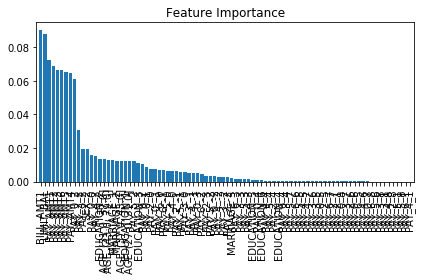

In [268]:
from sklearn.ensemble import RandomForestClassifier
feat_labels = Credit_train.columns[0:]
forest = RandomForestClassifier(n_estimators  = 500, random_state =1)
forest.fit(Credit_train, dpnm_train)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(Credit_train.shape[1]):
    print('%2d) %-*s %f' % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))
plt.title('Feature Importance')
plt.bar(range(Credit_train.shape[1]), importances[indices], align = 'center' )
plt.xticks(range(Credit_train.shape[1]), feat_labels[indices], rotation = 90)
plt.xlim([-1, Credit_train.shape[1]])
plt.tight_layout()
plt.show()

In [14]:
from sklearn.feature_selection import SelectFromModel
sfm = SelectFromModel(forest, threshold =0.01, prefit = True)
Credit_selected_X = sfm.transform (Credit_train)
Credit_selected_T = sfm.transform (Credit_test)
print("Number of features that meet this threshold criterion:", Credit_selected_X.shape[1])

Number of features that meet this threshold criterion: 25


In [15]:
for f in range (Credit_selected_X.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], 
                           importances[indices[f]]))

 1) BILL_AMT1                      0.090274
 2) LIMIT_BAL                      0.087649
 3) PAY_AMT1                       0.072111
 4) PAY_AMT2                       0.068987
 5) PAY_AMT3                       0.066330
 6) PAY_AMT6                       0.066278
 7) PAY_AMT5                       0.064967
 8) PAY_AMT4                       0.064663
 9) PAY_0_2                        0.061280
10) PAY_2_2                        0.030619
11) PAY_3_2                        0.019451
12) SEX_2                          0.019100
13) PAY_0_0                        0.015764
14) PAY_4_2                        0.015395
15) EDUCATION_2                    0.013621
16) AGE_(31.0, 37.0]               0.013558
17) AGE_(43.0, 79.0]               0.013109
18) MARRIAGE_1                     0.012539
19) MARRIAGE_2                     0.012480
20) AGE_(37.0, 43.0]               0.012228
21) EDUCATION_1                    0.012197
22) AGE_(27.0, 31.0]               0.012181
23) PAY_5_2                     

 1) BILL_AMT1                      0.090274
 2) LIMIT_BAL                      0.087649
 3) PAY_AMT1                       0.072111
 4) PAY_AMT2                       0.068987
 5) PAY_AMT3                       0.066330
 6) PAY_AMT6                       0.066278
 7) PAY_AMT5                       0.064967
 8) PAY_AMT4                       0.064663
 9) PAY_0_2                        0.061280
10) PAY_2_2                        0.030619
11) PAY_3_2                        0.019451
12) SEX_2                          0.019100
13) PAY_0_0                        0.015764
14) PAY_4_2                        0.015395
15) EDUCATION_2                    0.013621
16) AGE_(31.0, 37.0]               0.013558
17) AGE_(43.0, 79.0]               0.013109
18) MARRIAGE_1                     0.012539
19) MARRIAGE_2                     0.012480
20) AGE_(37.0, 43.0]               0.012228
21) EDUCATION_1                    0.012197
22) AGE_(27.0, 31.0]               0.012181
23) PAY_5_2                     

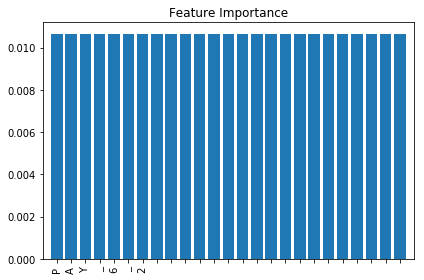

In [267]:
for f in range (Credit_selected_X.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], 
                           importances[indices[f]]))
plt.title('Feature Importance')
plt.bar(range(Credit_selected_X.shape[1]), importances[indices[f]], align = 'center', )
plt.xticks(range(Credit_selected_X.shape[1]), feat_labels[indices[f]], rotation = 90)
plt.xlim([-1, Credit_selected_X.shape[1]])
plt.tight_layout(),
plt.show()

### E. Standarización y escalamiento de los datos numéricos

In [17]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()


In [18]:
Credit_train[['LIMIT_BAL', 'BILL_AMT1', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']] = sc.fit_transform(Credit_train[['LIMIT_BAL', 'BILL_AMT1', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].values)

C:\Users\Framosb\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Framosb\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [19]:
Credit_train

,LIMIT_BAL,BILL_AMT1,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,"AGE_(27.0, 31.0]","AGE_(31.0, 37.0]",...,PAY_6_7,PAY_6_6,PAY_6_5,PAY_6_4,PAY_6_3,PAY_6_2,PAY_6_1,PAY_6_0,PAY_6_-1,PAY_6_-2
9133,-0.911362,-0.685320,-0.310659,-0.239439,-0.284617,-0.100401,-0.305303,-0.298519,0,0,...,0,0,0,0,1,0,0,0,0,0
21244,0.631742,-0.639650,2.871438,0.096959,-0.283916,0.071099,-0.304226,-0.009933,0,0,...,0,0,0,0,0,0,0,1,0,0
3209,-0.525586,-0.520664,-0.041130,-0.239439,0.053624,-0.055033,-0.178611,-0.298519,0,0,...,0,0,0,0,0,0,0,1,0,0
18344,-1.142828,-0.654511,-0.216073,-0.213630,-0.258246,0.146445,-0.297068,-0.298519,0,0,...,0,0,0,0,0,0,0,1,0,0
17487,-0.062655,0.563050,-0.130235,-0.095673,-0.124341,-0.116590,-0.164168,-0.170973,0,1,...,0,0,0,0,0,0,0,1,0,0
27769,-0.911362,-0.034608,-0.210242,-0.158820,-0.200380,1.299480,-0.191280,-0.182621,0,0,...,0,0,0,0,0,0,0,1,0,0
15321,0.786052,-0.356239,0.262279,0.395141,0.793959,1.483907,1.088304,-0.192994,0,0,...,0,0,0,0,0,0,0,1,0,0
22154,0.245966,-0.667011,-0.332702,0.012430,-0.284617,-0.301263,-0.305303,-0.298519,1,0,...,0,0,0,0,0,0,0,1,0,0
23437,0.477431,-0.692486,-0.332702,-0.214906,-0.284617,-0.301263,-0.305303,-0.298519,0,1,...,0,0,0,0,0,0,0,0,0,1
27363,-0.294121,0.280195,-0.216073,-0.239439,-0.284617,-0.301263,-0.305303,-0.298519,0,0,...,0,0,0,0,0,0,0,0,0,1


In [20]:
Credit_test[['LIMIT_BAL', 'BILL_AMT1', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']] = sc.transform(Credit_test[['LIMIT_BAL', 'BILL_AMT1', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].values)

C:\Users\Framosb\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Framosb\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [21]:
Credit_test

,LIMIT_BAL,BILL_AMT1,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,"AGE_(27.0, 31.0]","AGE_(31.0, 37.0]",...,PAY_6_7,PAY_6_6,PAY_6_5,PAY_6_4,PAY_6_3,PAY_6_2,PAY_6_1,PAY_6_0,PAY_6_-1,PAY_6_-2
14724,-0.757052,0.029737,-0.202661,-0.159498,-0.201729,-0.203448,-0.204076,-0.202671,0,0,...,0,0,0,0,0,0,0,1,0,0
15704,2.560622,-0.456848,0.639165,0.425378,0.614160,1.786955,-0.305303,0.667258,0,0,...,0,0,0,0,0,1,0,0,0,0
481,-0.216965,1.090432,0.658642,-0.239439,0.330171,-0.267406,0.030430,0.014405,0,0,...,0,0,0,0,0,1,0,0,0,0
19353,-0.911362,-0.278132,-0.216073,-0.159658,-0.176760,-0.301263,-0.305303,-0.298519,0,0,...,0,0,0,0,0,0,0,0,0,1
17042,1.017518,-0.337468,-0.001885,0.039795,0.119310,-0.118930,-0.305303,-0.298519,0,0,...,0,0,0,0,0,0,0,0,1,0
22106,0.477431,-0.626974,-0.216073,-0.117773,-0.014973,0.006525,0.011426,-0.008774,1,0,...,0,0,0,0,0,0,0,1,0,0
25029,1.017518,3.141695,0.834984,0.559770,0.071852,0.929888,-0.051919,-0.055133,0,0,...,0,0,0,0,0,0,0,1,0,0
6445,0.245966,-0.487182,-0.222138,-0.091365,-0.264178,-0.226348,0.306111,-0.297592,0,0,...,0,0,0,0,0,0,0,0,1,0
15116,-0.911362,-0.032885,-0.216890,-0.174098,-0.223678,-0.273624,-0.278824,-0.274412,0,0,...,0,0,0,0,0,0,0,1,0,0
8304,1.017518,3.076197,0.367362,0.165650,0.038956,0.006525,0.074772,0.049175,0,0,...,0,0,0,0,0,0,0,1,0,0


###  Modelo no supervisado: Principal Component Analysis


In [22]:
from sklearn.decomposition import PCA


In [23]:
#PCA analysis
from  sklearn.linear_model import LogisticRegression    
pca = PCA(0.95)
RF = RandomForestClassifier(max_depth = 20, random_state = 0 )
Credit_train_pca = pca.fit_transform(Credit_train)
# It can find out how many components PCA choose after fitting the model using pca.n_components_
pca.n_components_


23

In [24]:
#Apply the mapping (transform) to both the training set and the test set
Credit_test_pca = pca.transform(Credit_test)
# Apply Logistic Regression (lr) to the Transformed Data
RF.fit(Credit_train_pca, dpnm_train)

C:\Users\Framosb\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [25]:
pca.explained_variance_ratio_


array([0.17182421, 0.12918128, 0.07440826, 0.0620738 , 0.06124359,
       0.05843462, 0.05359064, 0.04901917, 0.04552818, 0.04067285,
       0.03666483, 0.02564711, 0.02248626, 0.01731856, 0.01681527,
       0.01570647, 0.01408469, 0.01227744, 0.01055746, 0.0104167 ,
       0.00954937, 0.00738717, 0.00716296])

Performance Accuracy 0.7977777777777778


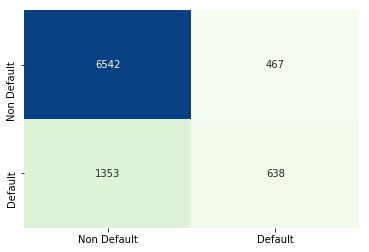

In [26]:
#Performance Evaluation
dpnm_pred= RF.predict(Credit_test_pca)
cm = confusion_matrix(dpnm_test, dpnm_pred)

print("Performance Accuracy", accuracy_score(dpnm_test, dpnm_pred))
sns.heatmap(cm, fmt = 'd', cmap = 'GnBu', cbar = False, annot = True,
            yticklabels = (['Non Default', 'Default']), xticklabels = (['Non Default', 'Default']))

#ax = plt.subplot()
#sns.heatmap(cm, annot = True, ax = ax); ax.set_ylabel('True labels')
#ax.set_title('Confusion Matrix')
#ax.set_xlabel('Predicted labels')
#ax.xaxis.set_ticklabels(['Non Default', 'Default']); ax.yaxis.set_ticklabels(['Non Default', 'Default']);


In [27]:
var1 = np.cumsum(np.round(pca.explained_variance_ratio_, decimals = 4)*100)

In [28]:
print(var1)

[17.18 30.1  37.54 43.75 49.87 55.71 61.07 65.97 70.52 74.59 78.26 80.82
 83.07 84.8  86.48 88.05 89.46 90.69 91.75 92.79 93.74 94.48 95.2 ]


Text(0, 0.5, 'Accumulated Variance')

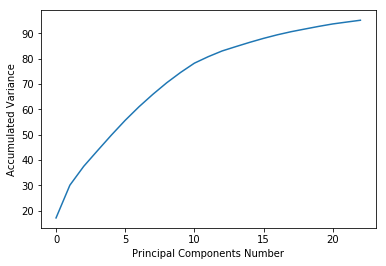

In [29]:
plt.plot(var1)
plt.xlabel('Principal Components Number')
plt.ylabel('Accumulated Variance')

## Modelling

Here we use the partition of dataset and also the performed featured scaling *standarize: Credit_train_std and Credit_test_std 

### A. Models

In [73]:
#Utility Function to report best results
def report(results, n_top=4):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

ModelBRF=BalancedRandomForestClassifier()
paramBRF_dist = {'n_estimators': sp_randint(1,200), 
               'max_depth': [1, None], 
               'max_features':sp_randint(0,88),
                'min_samples_split': sp_randint(2,20),
                'bootstrap':[True, False],
                'criterion':['gini', 'entropy'],
               'sampling_strategy': [0.5],
                }

#run randomized search
n_iter_search = 20
random_searchBRF = RandomizedSearchCV(ModelBRF,n_jobs = 3, param_distributions = paramBRF_dist, n_iter = n_iter_search,
                                   cv = 10, iid = False)

random_searchBRF.fit(Credit_train,dpnm_train)
start = time()
print('RandomizedSearchCV ModelBRF took %.2f seconds for %d candidates'
     ' parameter settings.' % ((time() - start),n_iter_search))
report(random_searchBRF.cv_results_)

RandomizedSearchCV ModelBRF took 0.00 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.814 (std: 0.004)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 1, 'max_features': 50, 'min_samples_split': 7, 'n_estimators': 197, 'sampling_strategy': 0.5}

Model with rank: 1
Mean validation score: 0.814 (std: 0.004)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 1, 'max_features': 80, 'min_samples_split': 8, 'n_estimators': 167, 'sampling_strategy': 0.5}

Model with rank: 1
Mean validation score: 0.814 (std: 0.004)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 1, 'max_features': 53, 'min_samples_split': 13, 'n_estimators': 171, 'sampling_strategy': 0.5}

Model with rank: 1
Mean validation score: 0.814 (std: 0.004)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 1, 'max_features': 43, 'min_samples_split': 17, 'n_estimators': 121, 'sampling_strategy': 0.5}



In [37]:
# 1. Model Random Forest Classifier

#Utility Function to report best results
def report(results, n_top=4):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

ModelRF=RandomForestClassifier()
paramRF_dist = {'n_estimators': [1,2,4,8,16,32,64,100,200], 
               'max_depth': [1, None], 
               'max_features':sp_randint(0,87),
                'min_samples_split': sp_randint(2,10),
                'bootstrap':[True, False],
                'criterion':['gini', 'entropy']}

#run randomized search
n_iter_search = 20
random_searchRF = RandomizedSearchCV(ModelRF,n_jobs = 3, param_distributions = paramRF_dist, n_iter = n_iter_search,
                                   cv = 10, iid = False)

random_searchRF.fit(Credit_train,dpnm_train)
start = time()
print('RandomizedSearchCV took %.2f seconds for %d candidates'
     ' parameter settings.' % ((time() - start),n_iter_search))
report(random_searchRF.cv_results_)


RandomizedSearchCV took 0.00 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.817 (std: 0.007)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': None, 'max_features': 33, 'min_samples_split': 5, 'n_estimators': 100}

Model with rank: 2
Mean validation score: 0.817 (std: 0.007)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': None, 'max_features': 18, 'min_samples_split': 5, 'n_estimators': 100}

Model with rank: 3
Mean validation score: 0.815 (std: 0.007)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 13, 'min_samples_split': 5, 'n_estimators': 32}

Model with rank: 4
Mean validation score: 0.814 (std: 0.006)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 24, 'min_samples_split': 8, 'n_estimators': 200}



In [39]:
# 2. Model KNeighborsClassifier


from scipy.stats import randint as sp_randint
from sklearn.neighbors import KNeighborsClassifier

#Utility Function to report best results
def report(results, n_top=4):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

ModelKNN=KNeighborsClassifier()
param_distKNN = {'n_neighbors': sp_randint(2,200), 
               'weights': ['uniform', 'distance'],
              'algorithm': ['ball_tree' , 'kd_tree', 'brute'], 
               'leaf_size':sp_randint(1, 50)                
                }
#run randomized search
n_iter_search = 20
random_searchKNN = RandomizedSearchCV(ModelKNN,
                                     n_jobs = 3,param_distributions = param_distKNN, 
                                     cv = 5, iid = False)
start = time()
print('RandomizedSearchCV took %.2f seconds for %d candidates'
     ' parameter settings.' % ((time() - start),n_iter_search))
random_searchKNN.fit(Credit_train,dpnm_train)

report(random_searchKNN.cv_results_)

RandomizedSearchCV took 0.00 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.814 (std: 0.005)
Parameters: {'algorithm': 'brute', 'leaf_size': 48, 'n_neighbors': 25, 'weights': 'uniform'}

Model with rank: 2
Mean validation score: 0.812 (std: 0.005)
Parameters: {'algorithm': 'kd_tree', 'leaf_size': 20, 'n_neighbors': 29, 'weights': 'uniform'}

Model with rank: 3
Mean validation score: 0.811 (std: 0.005)
Parameters: {'algorithm': 'kd_tree', 'leaf_size': 31, 'n_neighbors': 45, 'weights': 'uniform'}

Model with rank: 4
Mean validation score: 0.810 (std: 0.006)
Parameters: {'algorithm': 'kd_tree', 'leaf_size': 41, 'n_neighbors': 50, 'weights': 'distance'}



In [40]:
# 3. Model GaussianNB

ModelGNB=GaussianNB()

GNBscores = cross_validate(ModelGNB, Credit_train, dpnm_train, n_jobs= 3,
                          scoring = ['accuracy','roc_auc', 'neg_log_loss','recall', 'f1'],
                          return_train_score = False, return_estimator = False, cv = 10)
print(GNBscores)

{'fit_time': array([0.30281591, 0.29981637, 0.37077117, 0.34078836, 0.31080866,
       0.36177683, 0.35478139, 0.38376284, 0.33479333, 0.269835  ]), 'score_time': array([0.41574597, 0.3787663 , 0.33479929, 0.43572998, 0.42273903,
       0.40475154, 0.32680082, 0.30281377, 0.36477613, 0.21187043]), 'test_accuracy': array([0.7986673 , 0.80247501, 0.79390766, 0.79771537, 0.80533079,
       0.79847546, 0.79990472, 0.81086232, 0.80133397, 0.79418771]), 'test_roc_auc': array([0.72533454, 0.73667482, 0.75330205, 0.74533218, 0.74071628,
       0.73785854, 0.74232179, 0.72880879, 0.7444908 , 0.71678925]), 'test_neg_log_loss': array([-5.40788548, -4.53701043, -5.30630343, -5.65438273, -5.08608051,
       -5.68869652, -5.08136941, -4.79727692, -4.75331021, -5.97914826]), 'test_recall': array([0.21075269, 0.23010753, 0.17419355, 0.19569892, 0.22150538,
       0.16594828, 0.20905172, 0.25215517, 0.22844828, 0.16594828]), 'test_f1': array([0.31663974, 0.34022258, 0.27226891, 0.29983526, 0.33495935,


In [41]:
# 4. Model Gradient Boosting Classifier

#Utility Function to report best results
def report(results, n_top=4):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

ModelGBC=GradientBoostingClassifier()
param_distGBC = {'learning_rate': [1, 0.5, 0.25, 0.1, 0.05, 0.01], 
                'n_estimators': sp_randint(2,200),
                 'max_depth': sp_randint(1,32),
                 'min_samples_split': np.linspace(0.1, 1.0, 10, endpoint = True),
                 'min_samples_leaf': np.linspace(0.1, 0.5, 5, endpoint = True),
                 'max_features' : list(range(1,Credit_train.shape[1]))
                }
#run randomized search
n_iter_search = 20
random_searchGBC = RandomizedSearchCV(ModelGBC,
                                     n_jobs = 3,param_distributions = param_distGBC, 
                                     cv = 5, iid = False, n_iter = n_iter_search)
random_searchGBC.fit(Credit_train,dpnm_train)
start = time()
print('RandomizedSearchCV took %.2f seconds for %d candidates'
     ' parameter settings.' % ((time() - start),n_iter_search))

report(random_searchGBC.cv_results_)

RandomizedSearchCV took 0.00 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.818 (std: 0.005)
Parameters: {'learning_rate': 0.25, 'max_depth': 16, 'max_features': 75, 'min_samples_leaf': 0.1, 'min_samples_split': 0.4, 'n_estimators': 89}

Model with rank: 2
Mean validation score: 0.812 (std: 0.006)
Parameters: {'learning_rate': 0.1, 'max_depth': 8, 'max_features': 50, 'min_samples_leaf': 0.1, 'min_samples_split': 0.2, 'n_estimators': 51}

Model with rank: 3
Mean validation score: 0.809 (std: 0.005)
Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'max_features': 57, 'min_samples_leaf': 0.1, 'min_samples_split': 0.7000000000000001, 'n_estimators': 106}

Model with rank: 4
Mean validation score: 0.807 (std: 0.005)
Parameters: {'learning_rate': 0.05, 'max_depth': 17, 'max_features': 66, 'min_samples_leaf': 0.1, 'min_samples_split': 0.8, 'n_estimators': 168}



In [118]:
#Classification Report
from sklearn.metrics import classification_report

predict_dpnm_ModelBRF = random_searchBRF.predict(Credit_test)
classificationBRF = classification_report(dpnm_test,predict_dpnm_ModelBRF)
print('Results from ModelBRF','\n',classificationBRF)
 

predict_dpnm_ModelRF=random_searchRF.predict(Credit_test)
classificationRF = classification_report(dpnm_test,predict_dpnm_ModelRF)
print('Results from ModelRF','\n',classificationRF)

predict_dpnm_ModelKNN=random_searchKNN.predict(Credit_test)
classificationKNN = classification_report(dpnm_test,predict_dpnm_ModelKNN)
print('Results from ModelKNN','\n',classificationKNN)

predict_dpnm_ModelGBC=random_searchGBC.predict(Credit_test)
classificationGBC = classification_report(dpnm_test,predict_dpnm_ModelGBC)
print('Results from ModelGBC','\n',classificationGBC)



Results from ModelBRF 
               precision    recall  f1-score   support

           0       0.82      0.96      0.89      7009
           1       0.68      0.28      0.39      1991

    accuracy                           0.81      9000
   macro avg       0.75      0.62      0.64      9000
weighted avg       0.79      0.81      0.78      9000

Results from ModelRF 
               precision    recall  f1-score   support

           0       0.84      0.94      0.89      7009
           1       0.64      0.37      0.47      1991

    accuracy                           0.81      9000
   macro avg       0.74      0.66      0.68      9000
weighted avg       0.80      0.81      0.80      9000

Results from ModelKNN 
               precision    recall  f1-score   support

           0       0.83      0.95      0.89      7009
           1       0.66      0.31      0.42      1991

    accuracy                           0.81      9000
   macro avg       0.74      0.63      0.65      9000
wei

# Confusion Matrixes from Models

Performance Accuracy 0.8144444444444444


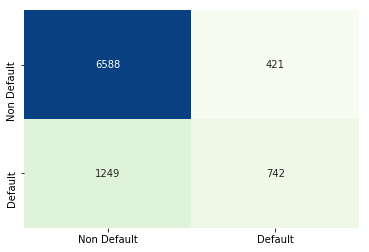

In [123]:
cmRF = confusion_matrix(dpnm_test, predict_dpnm_ModelRF, labels = [0, 1])

print("Performance Accuracy", accuracy_score(dpnm_test, predict_dpnm_ModelRF))
sns.heatmap(cmRF, fmt = 'd', cmap = 'GnBu', cbar = False, annot = True,
            yticklabels = (['Non Default', 'Default']), xticklabels = (['Non Default', 'Default']))

Performance Accuracy 0.8117777777777778


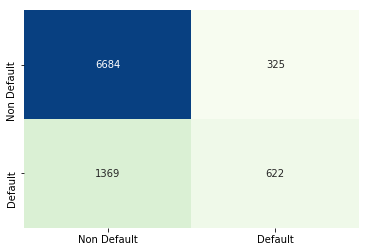

In [182]:
cmKNN = confusion_matrix(dpnm_test, predict_dpnm_ModelKNN)

print("Performance Accuracy", accuracy_score(dpnm_test, predict_dpnm_ModelKNN))
sns.heatmap(cmKNN, fmt = 'd', cmap = 'GnBu', cbar = False, annot = True,
            yticklabels = (['Non Default', 'Default']), xticklabels = (['Non Default', 'Default']))

Performance Accuracy 0.8124444444444444


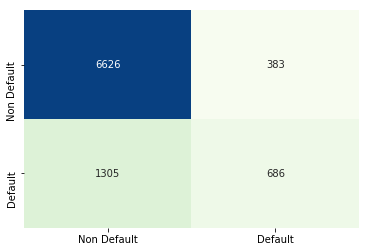

In [183]:
cmGBC = confusion_matrix(dpnm_test, predict_dpnm_ModelGBC)

print("Performance Accuracy", accuracy_score(dpnm_test, predict_dpnm_ModelGBC))
sns.heatmap(cmGBC, fmt = 'd', cmap = 'GnBu', cbar = False, annot = True,
            yticklabels = (['Non Default', 'Default']), xticklabels = (['Non Default', 'Default']))

Performance Accuracy 0.8123333333333334


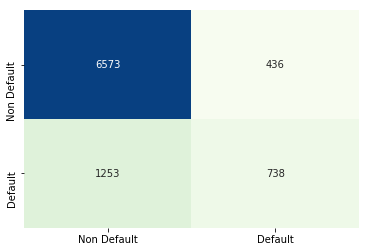

In [53]:
cmBRF = confusion_matrix(dpnm_test, predict_dpnm_ModelBRF)

print("Performance Accuracy", accuracy_score(dpnm_test, predict_dpnm_ModelBRF))
sns.heatmap(cmBRF, fmt = 'd', cmap = 'GnBu', cbar = False, annot = True,
            yticklabels = (['Non Default', 'Default']), xticklabels = (['Non Default', 'Default']))

# Precision Recall Curve robabilities

# When to Use ROC vs. Precision-Recall Curves?
Generally, the use of ROC curves and precision-recall curves are as follows:

ROC curves should be used when there are roughly equal numbers of observations for each class.
Precision-Recall curves should be used when there is a moderate to large class imbalance.
The reason for this recommendation is that ROC curves present an optimistic picture of the model on datasets with a class imbalance.

However, ROC curves can present an overly optimistic view of an algorithm’s performance if there is a large skew in the class distribution. […] Precision-Recall (PR) curves, often used in Information Retrieval , have been cited as an alternative to ROC curves for tasks with a large skew in the class distribution.

— The Relationship Between Precision-Recall and ROC Curves, 2006.

Some go further and suggest that using a ROC curve with an imbalanced dataset might be deceptive and lead to incorrect interpretations of the model skill.

[…] the visual interpretability of ROC plots in the context of imbalanced datasets can be deceptive with respect to conclusions about the reliability of classification performance, owing to an intuitive but wrong interpretation of specificity. [Precision-recall curve] plots, on the other hand, can provide the viewer with an accurate prediction of future classification performance due to the fact that they evaluate the fraction of true positives among positive predictions

— The Precision-Recall Plot Is More Informative than the ROC Plot When Evaluating Binary Classifiers on Imbalanced Datasets, 2015.

The main reason for this optimistic picture is because of the use of true negatives in the False Positive Rate in the ROC Curve and the careful avoidance of this rate in the Precision-Recall curve.

If the proportion of positive to negative instances changes in a test set, the ROC curves will not change. Metrics such as accuracy, precision, lift and F scores use values from both columns of the confusion matrix. As a class distribution changes these measures will change as well, even if the fundamental classifier performance does not. ROC graphs are based upon TP rate and FP rate, in which each dimension is a strict columnar ratio, so do not depend on class distributions.

In [127]:
predict_dpnm_ModelRF_prob=random_searchRF.predict_proba(Credit_test)[:,1]
ModelRF_auc_roc = roc_auc_score(dpnm_test, predict_dpnm_ModelRF_prob)
print(ModelRF_auc_roc)

0.7636474636649628


In [131]:
predict_dpnm_ModelKNN_prob=random_searchKNN.predict_proba(Credit_test)[:,1]
ModelKNN_auc_roc = roc_auc_score(dpnm_test, predict_dpnm_ModelKNN_prob)
print(ModelKNN_auc_roc)

0.7519525910540935


In [147]:
predict_dpnm_ModelGBC_prob=random_searchGBC.predict_proba(Credit_test)[:,1]
ModelGBC_auc_roc = roc_auc_score(dpnm_test, predict_dpnm_ModelGBC_prob)
print(ModelGBC_auc_roc)

0.7782608053833919


In [65]:
predict_dpnm_ModelBRF_prob=random_searchBRF.predict_proba(Credit_test)[:,1]
ModelBRF_auc_roc = roc_auc_score(dpnm_test, predict_dpnm_ModelBRF_prob)
print(ModelBRF_auc_roc)

0.7072401495128708


auc=0.535 ap=0.535


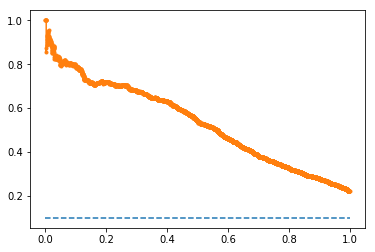

In [134]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import auc

predict_dpnm_ModelRF_prob=random_searchRF.predict_proba(Credit_test)[:,1]
precision, recall, thresholds = precision_recall_curve(dpnm_test, predict_dpnm_ModelRF_prob) 
#f1 = f1_score(dpnm_test, predict_dpnm_ModelBRF_prob)
auc = auc(recall, precision)
ap = average_precision_score(dpnm_test,predict_dpnm_ModelRF_prob)
print('auc=%.3f ap=%.3f' % (auc, ap))

#Plot no skill
plt.plot([0,1], [0.1,0.1], linestyle = '--')
#Plot the precision -recall curve for the model
plt.plot(recall, precision, marker  = '.')
#Show the plot
plt.show()

In [142]:
predict_dpnm_ModelRF_probAyB=random_searchRF.predict_proba(Credit_test)
predict_dpnm_ModelRF_probAyB

array([[0.957     , 0.043     ],
       [0.86333333, 0.13666667],
       [0.6115    , 0.3885    ],
       ...,
       [0.71680952, 0.28319048],
       [0.95      , 0.05      ],
       [0.88422222, 0.11577778]])

### The Best Model is RandomForestClassifier

# Calibration Curve

In [143]:
from sklearn.calibration import calibration_curve

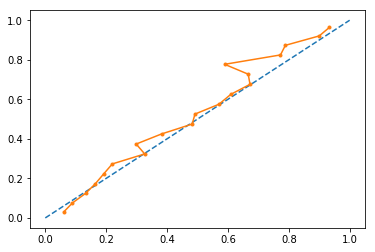

In [144]:
y_test, y_predic = calibration_curve(dpnm_test, predict_dpnm_ModelRF_prob, n_bins = 20)
plt.plot([0,1], [0,1], linestyle = '--')
plt.plot(y_test, y_predic , marker = '.')
plt.show()

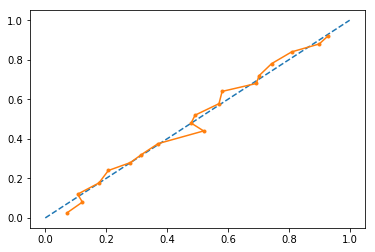

In [145]:
y_test, y_predic = calibration_curve(dpnm_test, predict_dpnm_ModelKNN_prob, n_bins = 20)
plt.plot([0,1], [0,1], linestyle = '--')
plt.plot(y_test, y_predic , marker = '.')
plt.show()

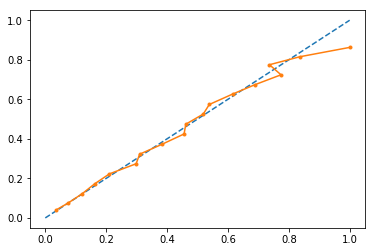

In [148]:
y_test, y_predic = calibration_curve(dpnm_test, predict_dpnm_ModelGBC_prob, n_bins = 20)
plt.plot([0,1], [0,1], linestyle = '--')
plt.plot(y_test, y_predic , marker = '.')
plt.show()

In [150]:
from sklearn.calibration import CalibratedClassifierCV

C:\Users\Framosb\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Framosb\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Framosb\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Framosb\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Framosb\Anaconda3\lib\site-packages\sklearn\ensemble\forest

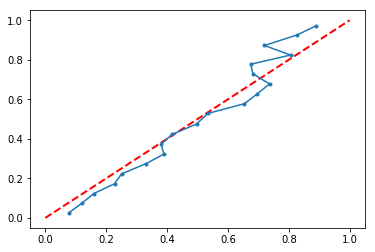

In [151]:
calibratedRF = CalibratedClassifierCV(ModelRF, method = 'sigmoid', cv = 5)
calibratedRF.fit(Credit_train, dpnm_train)
predict_dpnm_ModelRF_prob_cal = calibratedRF.predict_proba(Credit_test)[:,1]
y_test, y_predic = calibration_curve(dpnm_test, predict_dpnm_ModelRF_prob_cal, n_bins = 20, normalize = True)
plt.plot([0,1], [0,1], linestyle = '--', lw = 2, color = 'r')
plt.plot(y_test, y_predic , marker = '.')
plt.show()

In [199]:
for i in range (len(Credit_test)):
    print("Predicted=%s" % ( predict_dpnm_ModelRF_prob_cal[i]))

Predicted=0.10882984493945883
Predicted=0.13430575450435195
Predicted=0.3136721260869254
Predicted=0.13315205264216678
Predicted=0.11145186334494454
Predicted=0.10913507004125207
Predicted=0.17903109257383715
Predicted=0.14375952529765096
Predicted=0.18934831401320362
Predicted=0.13270670535976162
Predicted=0.12882422462774257
Predicted=0.14343650323077622
Predicted=0.24100238560119674
Predicted=0.1255401114696615
Predicted=0.18259448556025473
Predicted=0.16214574612959712
Predicted=0.38076578620687984
Predicted=0.15872917219365443
Predicted=0.12309243377055443
Predicted=0.11585871776033603
Predicted=0.1380479676274436
Predicted=0.33078419525606817
Predicted=0.16874451036615268
Predicted=0.10872298797479725
Predicted=0.1184985331309032
Predicted=0.27714862449238586
Predicted=0.183653149227132
Predicted=0.13445822727690745
Predicted=0.15702473288702445
Predicted=0.3100073713648944
Predicted=0.10167631818883863
Predicted=0.13299886332207494
Predicted=0.6277435475665324
Predicted=0.126847

Predicted=0.16065650371353352
Predicted=0.15310752013643314
Predicted=0.21433043567743965
Predicted=0.15856284352130426
Predicted=0.10882984493945883
Predicted=0.25308285069578534
Predicted=0.19731334060021252
Predicted=0.2049835579412938
Predicted=0.19341059395878984
Predicted=0.11631204073502074
Predicted=0.5880424196566443
Predicted=0.14224090171476264
Predicted=0.09419976937134371
Predicted=0.1606843846782128
Predicted=0.19338692224987072
Predicted=0.1805089721678863
Predicted=0.1864809861432185
Predicted=0.1305122372715996
Predicted=0.09419976937134371
Predicted=0.17703165078788186
Predicted=0.19222967429294663
Predicted=0.1013767400651124
Predicted=0.17212438924843623
Predicted=0.5162080916726011
Predicted=0.1685592093685009
Predicted=0.15515407643348017
Predicted=0.4199631215320525
Predicted=0.13478214986234918
Predicted=0.1160068156332275
Predicted=0.1480111424954138
Predicted=0.1549084086732502
Predicted=0.6425399038304337
Predicted=0.14789843394095065
Predicted=0.171470069259

Predicted=0.33664782604041676
Predicted=0.27607957026192337
Predicted=0.3444426570975483
Predicted=0.1230356884541047
Predicted=0.3117064992038504
Predicted=0.604606962400396
Predicted=0.10135329612196393
Predicted=0.48321266335141566
Predicted=0.25880345632169
Predicted=0.23122378256275372
Predicted=0.18355688507502427
Predicted=0.1184985331309032
Predicted=0.18254656090626864
Predicted=0.5385599184215367
Predicted=0.13446761155885528
Predicted=0.11618173982721072
Predicted=0.5899622937606164
Predicted=0.32276906932929894
Predicted=0.7361775490165554
Predicted=0.3704206387618556
Predicted=0.19080913356975418
Predicted=0.19014121774471024
Predicted=0.6475828086559947
Predicted=0.43361792952884964
Predicted=0.19359589495644164
Predicted=0.3413643642213343
Predicted=0.5583533006015415
Predicted=0.14145928125497215
Predicted=0.43775389762519124
Predicted=0.300566964403637
Predicted=0.3359236941808249
Predicted=0.6087042712155741
Predicted=0.2546918887339367
Predicted=0.7082993789970737
Pr

Predicted=0.12333526657783093
Predicted=0.12997223210810127
Predicted=0.17955332476148542
Predicted=0.5207328716302732
Predicted=0.18667221843905768
Predicted=0.555944963843656
Predicted=0.12583685280807397
Predicted=0.1186598821143053
Predicted=0.14748635187449582
Predicted=0.10842340985107105
Predicted=0.11072473490389459
Predicted=0.1566568614259628
Predicted=0.14551104721479677
Predicted=0.11818348675630805
Predicted=0.12495775966556973
Predicted=0.6911233377289663
Predicted=0.2469502541916438
Predicted=0.09419976937134371
Predicted=0.32833108407341594
Predicted=0.19564054458640107
Predicted=0.15543756666138203
Predicted=0.09419976937134371
Predicted=0.5714862190749286
Predicted=0.7209008711807676
Predicted=0.46864975841935397
Predicted=0.23080835865804872
Predicted=0.17719392269246545
Predicted=0.24372297271854312
Predicted=0.1013767400651124
Predicted=0.14466365146454963
Predicted=0.21951746248949364
Predicted=0.20019440633973645
Predicted=0.16655802872345843
Predicted=0.13593542

Predicted=0.10872298797479725
Predicted=0.1160068156332275
Predicted=0.10124643915730236
Predicted=0.10124643915730236
Predicted=0.1587658672473135
Predicted=0.31113766892530553
Predicted=0.7779188087161233
Predicted=0.2205883176032688
Predicted=0.22085278997908214
Predicted=0.6418290271517636
Predicted=0.10165852122375715
Predicted=0.10913507004125207
Predicted=0.11787826165451483
Predicted=0.11628859679187228
Predicted=0.14034227444644606
Predicted=0.15310752013643314
Predicted=0.5877185020045393
Predicted=0.11628859679187228
Predicted=0.326653212249956
Predicted=0.18034264349553614
Predicted=0.1729036577983806
Predicted=0.1268470026519385
Predicted=0.22948803428575718
Predicted=0.1158821617034845
Predicted=0.15322984535196363
Predicted=0.17925891895005525
Predicted=0.39528275028892185
Predicted=0.11557693660169126
Predicted=0.2451451776158342
Predicted=0.11787826165451483
Predicted=0.11072473490389459
Predicted=0.23144824650629509
Predicted=0.2531406355531642
Predicted=0.49020079643

Predicted=0.1381854726877812
Predicted=0.16523410017008955
Predicted=0.10167631818883863
Predicted=0.5701093214203554
Predicted=0.11860539009556477
Predicted=0.1711250799395746
Predicted=0.2934183786822855
Predicted=0.14941787240853133
Predicted=0.21410837201156677
Predicted=0.2481411033832115
Predicted=0.12762862311172896
Predicted=0.41329390225894597
Predicted=0.16402070168899452
Predicted=0.17908518488148067
Predicted=0.11631204073502074
Predicted=0.11860539009556477
Predicted=0.13549007274864944
Predicted=0.4673802985139794
Predicted=0.11834534381081137
Predicted=0.1589144731913062
Predicted=0.2227815119658422
Predicted=0.14253674253460807
Predicted=0.15541412271823357
Predicted=0.35194977618338913
Predicted=0.19627380226549024
Predicted=0.18147238408721847
Predicted=0.5043952999692463
Predicted=0.15322984535196363
Predicted=0.13561523474949363
Predicted=0.1233587105209794
Predicted=0.11855302514964372
Predicted=0.14030557939278698
Predicted=0.14564876828401968
Predicted=0.14722432

In [152]:
Credit_test['ProbsCal'] = predict_dpnm_ModelRF_prob_cal

C:\Users\Framosb\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [153]:
Credit_test.head()

,LIMIT_BAL,BILL_AMT1,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,"AGE_(27.0, 31.0]","AGE_(31.0, 37.0]",...,PAY_6_6,PAY_6_5,PAY_6_4,PAY_6_3,PAY_6_2,PAY_6_1,PAY_6_0,PAY_6_-1,PAY_6_-2,ProbsCal
14724,-0.757052,0.029737,-0.202661,-0.159498,-0.201729,-0.203448,-0.204076,-0.202671,0,0,...,0,0,0,0,0,0,1,0,0,0.111375
15704,2.560622,-0.456848,0.639165,0.425378,0.614160,1.786955,-0.305303,0.667258,0,0,...,0,0,0,0,1,0,0,0,0,0.133219
481,-0.216965,1.090432,0.658642,-0.239439,0.330171,-0.267406,0.030430,0.014405,0,0,...,0,0,0,0,1,0,0,0,0,0.279436
19353,-0.911362,-0.278132,-0.216073,-0.159658,-0.176760,-0.301263,-0.305303,-0.298519,0,0,...,0,0,0,0,0,0,0,0,1,0.158543
17042,1.017518,-0.337468,-0.001885,0.039795,0.119310,-0.118930,-0.305303,-0.298519,0,0,...,0,0,0,0,0,0,0,1,0,0.102303


In [154]:
Credit_test['Default Payment Next Month'] = dpnm_test 

C:\Users\Framosb\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [78]:
Credit_test.head()

,LIMIT_BAL,BILL_AMT1,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,"AGE_(27.0, 31.0]","AGE_(31.0, 37.0]",...,PAY_6_5,PAY_6_4,PAY_6_3,PAY_6_2,PAY_6_1,PAY_6_0,PAY_6_-1,PAY_6_-2,ProbsCal,Default Payment Next Month
14724,-0.757052,0.029737,-0.202661,-0.159498,-0.201729,-0.203448,-0.204076,-0.202671,0,0,...,0,0,0,0,0,1,0,0,0.117200,0
15704,2.560622,-0.456848,0.639165,0.425378,0.614160,1.786955,-0.305303,0.667258,0,0,...,0,0,0,1,0,0,0,0,0.138370,0
481,-0.216965,1.090432,0.658642,-0.239439,0.330171,-0.267406,0.030430,0.014405,0,0,...,0,0,0,1,0,0,0,0,0.265351,1
19353,-0.911362,-0.278132,-0.216073,-0.159658,-0.176760,-0.301263,-0.305303,-0.298519,0,0,...,0,0,0,0,0,0,0,1,0.168519,0
17042,1.017518,-0.337468,-0.001885,0.039795,0.119310,-0.118930,-0.305303,-0.298519,0,0,...,0,0,0,0,0,0,1,0,0.126754,0


(array([4528., 2044.,  736.,  397.,  320.,  318.,  290.,  212.,  117.,
          38.]),
 array([0.09496742, 0.16483945, 0.23471149, 0.30458352, 0.37445556,
        0.44432759, 0.51419963, 0.58407166, 0.65394369, 0.72381573,
        0.79368776]),
 <a list of 10 Patch objects>)

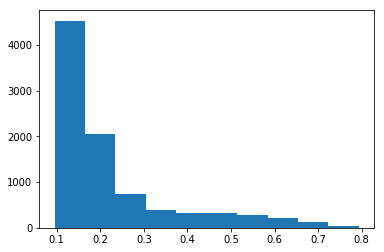

In [155]:
plt.hist( Credit_test['ProbsCal'], bins = 10)

In [177]:
Credit_test['Default Payment Next Month'] = dpnm_test 

C:\Users\Framosb\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [178]:
Credit_test['Predicted class'] = predict_dpnm_ModelRF

C:\Users\Framosb\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [179]:
Credit_test

,LIMIT_BAL,BILL_AMT1,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,"AGE_(27.0, 31.0]","AGE_(31.0, 37.0]",...,PAY_6_4,PAY_6_3,PAY_6_2,PAY_6_1,PAY_6_0,PAY_6_-1,PAY_6_-2,ProbsCal,Default Payment Next Month,Predicted class
14724,-0.757052,0.029737,-0.202661,-0.159498,-0.201729,-0.203448,-0.204076,-0.202671,0,0,...,0,0,0,0,1,0,0,0.111375,0,0
15704,2.560622,-0.456848,0.639165,0.425378,0.614160,1.786955,-0.305303,0.667258,0,0,...,0,0,1,0,0,0,0,0.133219,0,0
481,-0.216965,1.090432,0.658642,-0.239439,0.330171,-0.267406,0.030430,0.014405,0,0,...,0,0,1,0,0,0,0,0.279436,1,0
19353,-0.911362,-0.278132,-0.216073,-0.159658,-0.176760,-0.301263,-0.305303,-0.298519,0,0,...,0,0,0,0,0,0,1,0.158543,0,0
17042,1.017518,-0.337468,-0.001885,0.039795,0.119310,-0.118930,-0.305303,-0.298519,0,0,...,0,0,0,0,0,1,0,0.102303,0,0
22106,0.477431,-0.626974,-0.216073,-0.117773,-0.014973,0.006525,0.011426,-0.008774,1,0,...,0,0,0,0,1,0,0,0.145921,0,0
25029,1.017518,3.141695,0.834984,0.559770,0.071852,0.929888,-0.051919,-0.055133,0,0,...,0,0,0,0,1,0,0,0.170973,0,0
6445,0.245966,-0.487182,-0.222138,-0.091365,-0.264178,-0.226348,0.306111,-0.297592,0,0,...,0,0,0,0,0,1,0,0.148707,1,0
15116,-0.911362,-0.032885,-0.216890,-0.174098,-0.223678,-0.273624,-0.278824,-0.274412,0,0,...,0,0,0,0,1,0,0,0.166726,0,0
8304,1.017518,3.076197,0.367362,0.165650,0.038956,0.006525,0.074772,0.049175,0,0,...,0,0,0,0,1,0,0,0.158054,0,0


In [253]:
z = Credit_test.loc[(Credit_test['ProbsCal']>=0.565) & (Credit_test['Default Payment Next Month'] == 1) ]
z

,LIMIT_BAL,BILL_AMT1,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,"AGE_(27.0, 31.0]","AGE_(31.0, 37.0]",...,PAY_6_4,PAY_6_3,PAY_6_2,PAY_6_1,PAY_6_0,PAY_6_-1,PAY_6_-2,ProbsCal,Default Payment Next Month,Predicted class
25590,-0.294121,1.080334,0.040510,-0.239439,-0.040050,-0.061189,-0.032916,-0.084108,0,0,...,0,0,0,0,1,0,0,0.698342,1,1
28453,1.480449,0.778709,-0.332702,0.239248,-0.284617,0.061927,0.011426,-0.037749,0,0,...,0,0,0,0,1,0,0,0.616053,1,1
26858,-0.911362,0.097067,-0.181085,-0.239439,-0.209117,-0.301263,-0.264191,1.561642,0,1,...,0,0,0,0,1,0,0,0.616107,1,1
5883,-1.142828,-0.472361,-0.235084,-0.181757,-0.225296,-0.301263,-0.281294,-0.235644,0,0,...,0,0,0,0,1,0,0,0.579942,1,1
27276,0.245966,-0.089738,-0.216073,-0.179603,-0.230688,-0.144907,-0.178611,-0.298519,1,0,...,0,0,1,0,0,0,0,0.649857,1,1
29138,-0.757052,-0.111399,-0.210242,-0.159658,-0.182153,-0.184304,-0.191280,-0.188416,0,0,...,0,0,1,0,0,0,0,0.767894,1,1
18259,-1.142828,-0.439802,-0.332702,-0.239439,-0.284617,-0.010342,-0.305303,-0.298519,0,0,...,1,0,0,0,0,0,0,0.575787,1,1
12609,-0.911362,-0.042019,-0.094196,-0.239439,-0.250480,-0.258419,-0.241957,-0.240570,0,0,...,0,0,0,0,1,0,0,0.577938,1,1
21052,-0.757052,0.128812,-0.157759,-0.143702,-0.176760,-0.116590,-0.146431,-0.298519,0,1,...,0,0,1,0,0,0,0,0.705801,1,1
17614,-0.679897,-0.140728,-0.216073,-0.159658,-0.214510,-0.178148,-0.184946,-0.188416,1,0,...,0,0,1,0,0,0,0,0.645734,1,1


In [254]:
z['Predicted class'].value_counts()

1    320
0      5
Name: Predicted class, dtype: int64

In [255]:
z['Default Payment Next Month'].value_counts()

1    325
0      0
Name: Default Payment Next Month, dtype: int64